# PCA Brasil  


Para fazer commit: `Ctrl + Shift + m`   
Reposotório: `spatial_cluster`   
Caminho do arquivo: `scripts/sul/centroides_brasil.ipynb`

## Bibliotecas

In [1]:
#!pip install geopandas==0.8.1
#!pip install --upgrade pyshp
#!pip install shapely==1.7.0
#!pip install --upgrade descartes
#!pip install mapclassify==2.3.0 libpysal==4.3.0 splot==1.1.3
#!pip install esda

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as stats

# para gráficos
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set(style='whitegrid', palette='pastel') 

# para a análise de componentes principais
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

# para a análise de dados espaciais
import geopandas
import splot
import mapclassify as mc
from libpysal.weights import Queen
from esda import Moran, Moran_Local, G_Local
from splot.esda import plot_moran, moran_scatterplot, lisa_cluster, plot_local_autocorrelation

# para agrupamento - K-médias
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import cut_tree
from sklearn.cluster import KMeans, AgglomerativeClustering

# para avaliar grupos 
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics.cluster import contingency_matrix


## Dados

https://www.gov.br/agricultura/pt-br/assuntos/riscos-seguro/seguro-rural/relatorios-estatisticos

In [3]:
link = 'https://raw.githubusercontent.com/walefmachado/spatial_cluster/master/data/'

In [4]:
# função para deixar todos os nomes de municípios iguais (sem acento, sem espaço)
def simplificar_nomes(df, variavel):
  df[variavel] = (df[variavel].str.strip()
                 .str.lower()
                 .str.replace(' ', '_')
                 .str.replace('\'', '')
                 .str.replace('-','_')
                 .str.replace('á', 'a')
                 .str.replace('é', 'e')
                 .str.replace('í', 'i')
                 .str.replace('ó', 'o')
                 .str.replace('ú', 'u')
                 .str.replace('â', 'a')
                 .str.replace('ê', 'e')
                 .str.replace('ô', 'o')
                 .str.replace('í', 'i')
                 .str.replace('ã','a')
                 .str.replace('õ','o')
                 .str.replace('ç','c')
                 .str.replace('à', 'a')
                 .str.replace('ü', 'u'))

### Dados de seguro rural

In [5]:
dados18 = pd.read_csv(link+'/seguro18.csv', encoding='utf-8')
dados18.head()

,ano,uf,nome_mun,cultura,seguradora,evento_sinistro,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas
0,2018,AC,Rio Branco,Pecuário,Mapfre,-,2,988246.80,9892.13,4451.45,0.00,0.0,0.01,0
1,2018,AL,Igaci,Milho 1ª safra,Aliança do Brasil,SECA,1,646644.90,51309.86,23089.44,514018.03,10018.0,79.00,1
2,2018,AL,Limoeiro de Anadia,Milho 1ª safra,Sancor,-,1,322882.69,29059.47,13076.76,0.00,0.0,0.09,0
3,2018,AL,Messias,Pecuário,Mapfre,-,1,386600.00,3869.78,1741.40,0.00,0.0,0.01,0
4,2018,AL,Santana do Mundaú,Pecuário,Mapfre,-,1,165920.00,1660.82,747.36,0.00,0.0,0.01,0


In [6]:
dados = dados18
cod = pd.read_csv(link+'/codigos-mun.csv')
cod = cod[['mun', 'nome_mun', 'nome_meso']]
cod.shape

(5570, 3)

In [7]:
# simplificar os nomes dos municípios nos dois dataframes
simplificar_nomes(cod, 'nome_mun')
simplificar_nomes(dados, 'nome_mun')

In [8]:
dados = dados.merge(cod, on='nome_mun', how='left')
dados.shape

(15395, 16)

In [9]:
dados = dados.drop('ano', axis=1).groupby('mun').sum()

In [10]:
dados.reset_index(level = 0, inplace = True)

In [11]:
dados.shape

(2293, 9)

In [12]:
dados = dados.merge(cod, on='mun')

In [13]:
dados.head()

,mun,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas,nome_mun,nome_meso
0,1100023.0,1,2300000.00,18456.81,8305.56,0.00,0.0,8.00,0,ariquemes,Leste Rondoniense
1,1100056.0,2,195143.31,10732.87,4829.80,0.00,0.0,55.00,0,cerejeiras,Leste Rondoniense
2,1100072.0,2,2548975.13,222758.25,89103.30,0.00,0.0,87.00,0,corumbiara,Leste Rondoniense
3,1100130.0,1,153645.48,9218.72,4148.42,0.00,0.0,0.06,0,machadinho_doeste,Leste Rondoniense
4,1100403.0,2,154950.18,9028.44,4062.80,39291.79,4352.0,58.00,2,alto_paraiso,Leste Rondoniense


In [14]:
retirar = ['sinistralidade_media', 'taxa_media']
dados = dados.drop(retirar, axis=1)
dados.head()

,mun,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,apolices_indenizadas,nome_mun,nome_meso
0,1100023.0,1,2300000.00,18456.81,8305.56,0.00,0,ariquemes,Leste Rondoniense
1,1100056.0,2,195143.31,10732.87,4829.80,0.00,0,cerejeiras,Leste Rondoniense
2,1100072.0,2,2548975.13,222758.25,89103.30,0.00,0,corumbiara,Leste Rondoniense
3,1100130.0,1,153645.48,9218.72,4148.42,0.00,0,machadinho_doeste,Leste Rondoniense
4,1100403.0,2,154950.18,9028.44,4062.80,39291.79,2,alto_paraiso,Leste Rondoniense


In [15]:
seguro = dados # não sei porque fiz isso.. rs 

### Dados para espacial 

In [16]:
# seguro = pd.read_csv(link_p+'seguroagricola2017.csv', encoding='latin1') # troquei para 2018
cod = pd.read_csv(link+'cod-nome-corrigido.csv', encoding='latin1')

br = geopandas.read_file(link+'br.json')
br = br.rename(columns={'CD_GEOCMU': 'mun'})
br.mun = br.mun.astype(int)
br2 = br.drop('NM_MUNICIP', axis=1)

In [17]:
cod_dados = cod.merge(br2, how='left')
cod_dados = geopandas.GeoDataFrame(cod_dados) # Ate aqui junta geometry com todos os códigos 

In [18]:
# apolices = seguro.groupby('nome_mun').apolices_contratadas.sum()
# apolices = pd.DataFrame(apolices).reset_index()

In [19]:
dados_br = cod_dados.merge(seguro, how='left')

In [20]:
dados_br = dados_br.fillna(0)
dados_br = dados_br.drop([1525, 3499]) # retira F. Noronha e Ilhabela
dados_br = dados_br.drop(['Unnamed: 0', 'rm'], axis = 1)

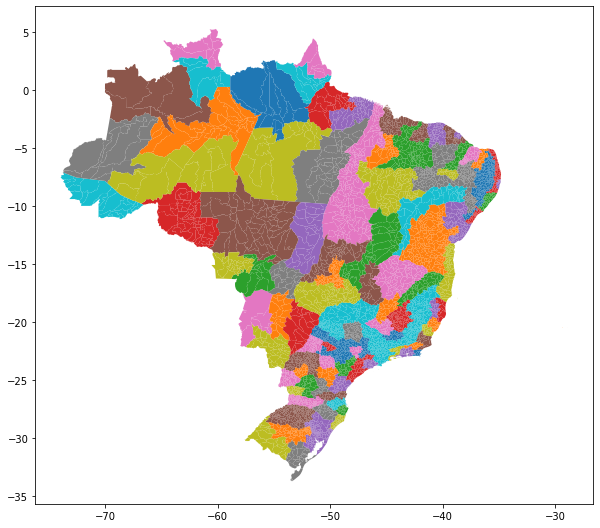

In [21]:
# dados_br.plot(column='apolices', figsize=(10, 10), scheme='quantiles', cmap='OrRd', legend=True, k=4);
dados_br.plot(column='nome_meso', figsize=(10, 10)); # , cmap='OrRd',  cmap='plasma'

## Centroides




In [22]:
dados_br.geometry.centroid.x

dados_br['x_centroid'] = dados_br.geometry.centroid.x
dados_br['y_centroid'] = dados_br.geometry.centroid.y

/home/walef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.
/home/walef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  This is separate from the ipykernel package so we can avoid doing imports until
/home/walef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  after removing the cwd from sys.path.


In [23]:
dados_centroids = dados_br
retirar = ['uf', 'nome_uf', 'mun', 'meso', 'nome_meso', 
           'micro', 'nome_micro', 'codmun6', 'regiao', 
           'nome_regiao'] # 
dados_centroids = dados_centroids.drop(retirar, axis = 1)

## Análise de componentes principais - Centroides

In [24]:
# subselecionar variáveis
X = dados_centroids.iloc[:,2:]

In [25]:
X.head()

,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,apolices_indenizadas,x_centroid,y_centroid
0,0.0,0.00,0.00,0.00,0.0,0.0,-62.274713,-12.469912
1,1.0,2300000.00,18456.81,8305.56,0.0,0.0,-62.958639,-9.951792
2,0.0,0.00,0.00,0.00,0.0,0.0,-60.640047,-13.474851
3,0.0,0.00,0.00,0.00,0.0,0.0,-61.324997,-11.300996
4,2.0,195143.31,10732.87,4829.80,0.0,0.0,-61.260047,-13.203538


In [26]:
# efetua a ACP
pca = PCA() 
resultado_pca = pca.fit_transform(scale(X))   # scale(X) padroniza os dados, como se usássemos a matriz R

In [27]:
resultado = pd.DataFrame({'cp1':resultado_pca[:, 0], 'cp2':resultado_pca[:, 1]}, index=X.index)

In [28]:
# os cinco primeiros CPs
pca.components_[0:5, :]

array([[ 0.42058612,  0.41506351,  0.41560502,  0.41705467,  0.37400764,
         0.36619632, -0.12006852, -0.12557686],
       [ 0.04306323,  0.04671947,  0.06647102,  0.066727  ,  0.11497627,
         0.0946228 ,  0.69682548,  0.69235337],
       [ 0.1463864 , -0.31822666, -0.40287791, -0.3851387 ,  0.46833429,
         0.58639226, -0.01202733, -0.05764411],
       [-0.05707031,  0.02992392, -0.01475083, -0.01827803,  0.07077757,
         0.00635775, -0.70532702,  0.7019685 ],
       [-0.67792323,  0.23179207,  0.03708935, -0.0024358 ,  0.65575765,
        -0.21319009,  0.03575084, -0.09254594]])

In [29]:
# variâncias dos CPs (autovalores)
pca.explained_variance_

array([4.81482166e+00, 1.34632173e+00, 9.07385558e-01, 5.55782539e-01,
       2.32653720e-01, 1.07387973e-01, 3.63904689e-02, 6.93389201e-04])

In [30]:
# variância explicada acumulada
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

array([ 60.17,  77.  ,  88.34,  95.29,  98.2 ,  99.54,  99.99, 100.  ])

In [31]:
# alguns escores dos dois primeiros CPs
resultado.head(10)

,cp1,cp2
0,-0.339532,-1.500862
1,-0.225085,-1.347638
2,-0.354816,-1.407739
3,-0.375008,-1.300123
4,-0.307201,-1.447306
5,-0.361301,-1.371497
6,0.034692,-1.355250
7,-0.311101,-1.667283
8,-0.384335,-1.245772
9,-0.314936,-1.648736


In [32]:
resultado.index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            5560, 5561, 5562, 5563, 5564, 5565, 5566, 5567, 5568, 5569],
           dtype='int64', length=5568)

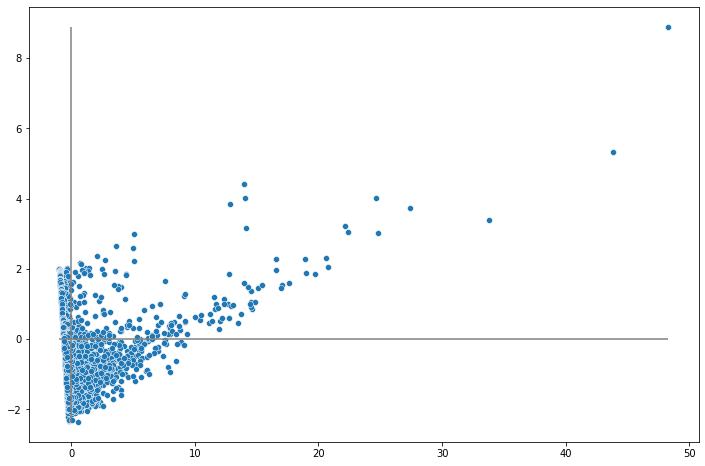

In [33]:
### diagrama de dispersão dos escores dos CPs com os nomes dos municípios ???? 
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
ax.scatter(resultado.cp1, resultado.cp2, edgecolor="white", linewidth=.5);
#for i, txt in enumerate(dados.nome_mun):
#    ax.annotate(txt, (resultado.cp1[i], resultado.cp2[i]), alpha=.5)
plt.hlines(0, resultado_pca[:, 0].min(), resultado_pca[:, 0].max(), color='gray')
plt.vlines(0, resultado_pca[:, 1].min(), resultado_pca[:, 1].max(), color='gray');

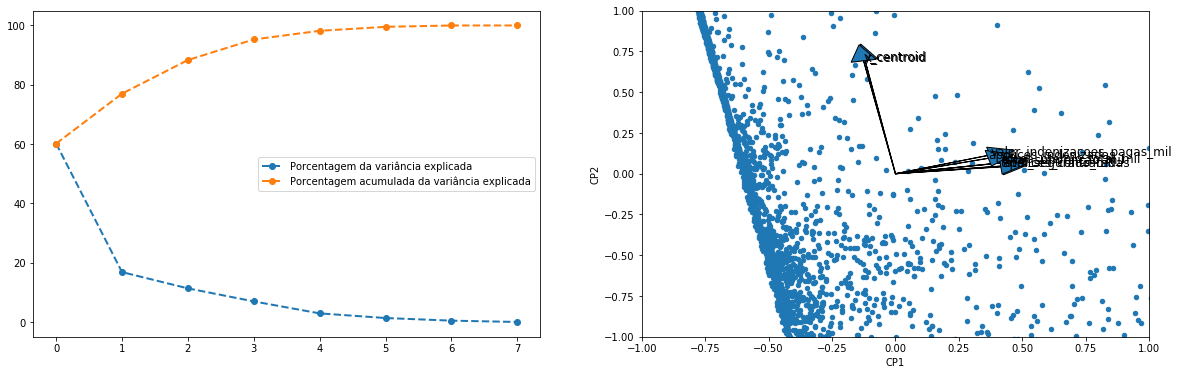

In [34]:
# mostra o gráfico com as variâncias explicadas pelos CPs
# e as correlações de cada variável com cada CP
def get_angle(v1, v2):
    # calcula ângulo entre dois vetores
    cosang = np.dot(v1, v2)
    sinang = np.linalg.norm(np.cross(v1, v2))
    return np.degrees(np.arctan2(sinang, cosang))

def annotate_embedding(loadings, pc_x, pc_y, ax, scaling=10, n_features=10, angle_thr=20):
    # função para adicionar loadings no gráfico
    loadings['VectorLength'] = np.sqrt(loadings[pc_x]**2 + loadings[pc_y]**2)
    loadings = loadings.sort_values(by='VectorLength', ascending=False)
    
    # plota cada um dos maiores vetores 
    for feature, row in loadings.iloc[0:n_features].iterrows():
        vector = np.array([row[pc_x]*scaling, row[pc_y]*scaling])
        ax.arrow(0, 0, vector[0], vector[1], head_width=0.1, head_length=0.1)
        ax.annotate(feature, xy=(0, 0), xytext=(vector[0], vector[1]), fontsize=12)
    
    # retorna lista ordenada
    top_features = loadings.index.tolist()
    return top_features

# cria um dataframe com os resultados da ACP
pca_df = pd.DataFrame(
    resultado_pca,
    index=X.index,
    columns=['CP' + str(i + 1) for i in range(resultado_pca.shape[1])]
)

import itertools
# cria dois gráficos
_, axes = plt.subplots(ncols=2, figsize=(20, 6))  # número de colunas e tamanho

# plota a variância explicada
axes[0].plot(
    pca.explained_variance_ratio_*100, "--o", linewidth=2,
    label='Porcentagem da variância explicada'
)

# plota a variância explicada acumulada
axes[0].plot(
    (pca.explained_variance_ratio_ * 100).cumsum(), "--o", linewidth=2,
    label='Porcentagem acumulada da variância explicada'
)

# mostra legenda
axes[0].legend(loc='best', frameon=True)
    
# loadings de cada componente
loadings = pd.DataFrame(
    pca.components_,
    index=['CP'+str(i+1) for i in range(len(pca.components_))],
    columns=X.columns
).T

# plota os componentes
i = 1
x, y = 'CP'+str(i), 'CP'+str(i+1)
# plotar
settings = {'kind': 'scatter', 'ax': axes[i], 'alpha': 1, 'x': x, 'y': y}
pca_df.plot(label=None, **settings)
plt.xlim(-1,1)
plt.ylim(-1,1)
# mostrar os loadings
annotate_embedding(loadings, x, y, axes[i], scaling=1, n_features=20, angle_thr=20)
    
# faz aparecer o gráfico
plt.show();

## Selecionar componentes principais

In [35]:
# variâncias acumuladas
tot = sum(pca.explained_variance_)
var_exp = [(i / tot)*100 for i in sorted(pca.explained_variance_, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
cum_var_exp

array([ 60.17446157,  77.0004608 ,  88.34074323,  95.28677725,
        98.19442645,  99.53653503,  99.99133419, 100.        ])

In [36]:
# número de CPs gerados (k = p)
cp =['CP'+str(i+1) for i in range(len(pca.components_))]

In [37]:
# dataframe com as variâncias acumuladas para criar o scree plot
df = pd.DataFrame({'cp': cp, 'var_exp': var_exp, 'cum_var_exp': cum_var_exp})
df

,cp,var_exp,cum_var_exp
0,CP1,60.174462,60.174462
1,CP2,16.825999,77.000461
2,CP3,11.340282,88.340743
3,CP4,6.946034,95.286777
4,CP5,2.907649,98.194426
5,CP6,1.342109,99.536535
6,CP7,0.454799,99.991334
7,CP8,0.008666,100.000000


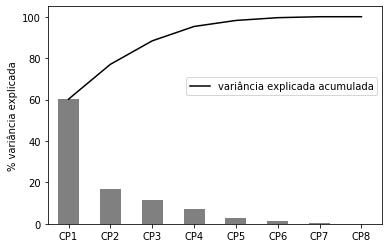

In [38]:
# scree plot
fig, ax = plt.subplots()
df.plot.bar('cp', 'var_exp', color='gray', ax=ax, legend=False)
df.plot.line('cp', 'cum_var_exp', color='black', ax=ax)
plt.legend(labels=['variância explicada acumulada'],
           loc='upper right', 
           bbox_to_anchor=(1, 0.7))
plt.ylabel('% variância explicada')
plt.xlabel('');

## Análise de agrupamento - Score dos componentes

In [39]:
# subselecionar variáveis
XX = resultado
XX = np.asarray(XX, dtype=float)
n = XX.shape[0]
p = XX.shape[1]
# vetor de médias
Xb = np.mean(XX, axis=0)
# matriz de covariâncias
S = np.cov(XX.T)
# matriz de somas de quadrados e produtos
W = (n - 1) * S

In [40]:
Z = linkage(XX, method='ward')

In [41]:
max_d = 0
grupos = cut_tree(Z, height=max_d)

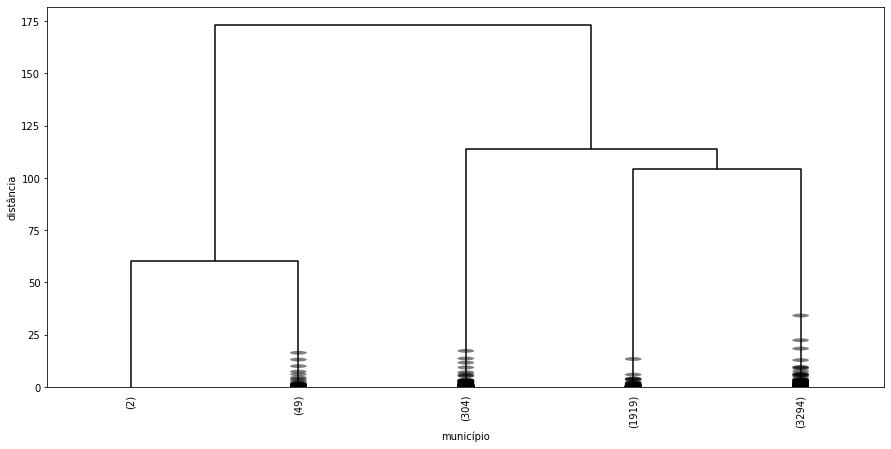

In [42]:
fig, ax = plt.subplots(figsize=(15, 7))
ax = dendrogram(
    Z,
    truncate_mode='lastp',  # mostrar apenas os p últimos grupos formados
    p=5,  # quantos passos mostrar
    show_leaf_counts=True,  # mostrar quantas observações há em cada grupo entre parênteses
    leaf_rotation=90., # rotação
    leaf_font_size=10., # tamanho da fonte
    labels=dados.index, # rótulos do eixo x
    show_contracted=True,  # to get a distribution impression in truncated branches,
    above_threshold_color='black',
    color_threshold=0.1, # para que todas as linhas sejam da mesma cor
    # color_threshold=max_d, # para que os grupos fiquem com cores diferentes
)
plt.axhline(y=max_d, c='grey', lw=1, linestyle='dashed')
plt.xlabel('município')
plt.ylabel('distância');

In [43]:
## definir a distância de corte baseando no dendrograma
max_d = 75
grupos = cut_tree(Z, height=max_d)

### Métricas

In [44]:
# métricas
print(
  round(metrics.calinski_harabasz_score(X, grupos.ravel()),2),
  round(davies_bouldin_score(X, grupos.ravel()),2),
  round(metrics.silhouette_score(X, grupos.ravel(), metric='euclidean'),2)  
)

4860.91 1.16 -0.05


In [45]:
# incluir no dataframe de dados as informações sobre a qual grupo cada observação pertence
dados_centroids['grupo'] = grupos
# moran_matrix.head(2)

In [46]:
# contagem de observações em cada grupo
dados_centroids.grupo.value_counts()

0    3294
1    1919
2     304
3      51
Name: grupo, dtype: int64

In [47]:
# média dos grupos - todas as variáveis
# inclusive as não utilizadas para agrupar
dados_centroids.groupby('grupo').mean()

,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,apolices_indenizadas,x_centroid,y_centroid
grupo,,,,,,,,
0,6.231330,1.398109e+06,8.185677e+04,3.485922e+04,5.941889e+04,1.076503,-49.258046,-20.851794
1,0.390829,1.025844e+05,5.851456e+03,2.552195e+03,7.881688e+03,0.071391,-40.248743,-7.814333
2,109.351974,1.976104e+07,1.387621e+06,5.983334e+05,1.567559e+06,32.108553,-50.741484,-22.240204
3,335.470588,6.602679e+07,5.352698e+06,2.283252e+06,6.901872e+06,126.725490,-51.085296,-22.903344


In [48]:
# mediana das variáveis para cada grupo
dados_centroids.groupby('grupo').median()

,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,apolices_indenizadas,x_centroid,y_centroid
grupo,,,,,,,,
0,1.0,68970.00,2884.925,1270.555,0.00,0.0,-49.307809,-21.400289
1,0.0,0.00,0.000,0.000,0.00,0.0,-39.482782,-7.240977
2,93.5,17537747.42,1182317.165,512813.090,1189047.70,24.0,-51.372684,-23.466372
3,320.0,59805915.79,4282426.370,1876541.660,5502523.96,93.0,-51.552312,-23.514218


### As observações de cada grupo

In [49]:
#grupo0 = dados.query('grupo == 0').index
#list(grupo0)

### Mapa Grupos Centroides

In [50]:
dados_centroids['grupo'] = dados_centroids['grupo'].astype('category')

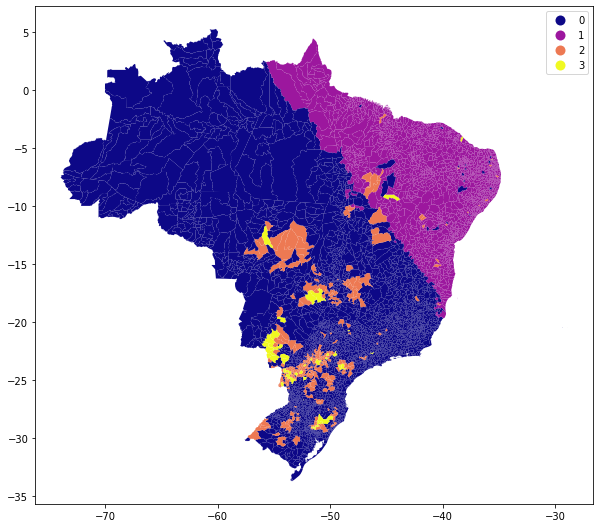

In [51]:
dados_centroids.plot(column='grupo', figsize=(10, 10), legend=True, cmap='plasma'); # , cmap='OrRd'

## K-Médias

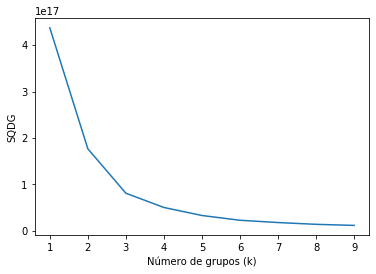

In [52]:
# SQDG
SQDG = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(dados_centroids.drop(['nome_mun', 'geometry'], axis=1))
    dados_centroids['grupos'] = kmeans.labels_
    SQDG[k] = kmeans.inertia_ # Inertia: soma das distâncias das obs. ao centro mais próximo
plt.figure()
plt.plot(list(SQDG.keys()), list(SQDG.values()))
plt.xlabel('Número de grupos (k)')
plt.ylabel('SQDG');

In [53]:
k = 4

In [54]:
kmeans = KMeans(n_clusters=k, random_state=10).fit(X)

In [55]:
# incluir no resultado dos escores dos dois primeiros CPs a informação sobre os grupos obtidos 
# com o método das k-médias
dados_centroids['grupo'] = kmeans.labels_

### Métricas

In [56]:
print(
  round(metrics.calinski_harabasz_score(X, kmeans.labels_),2),
  round(davies_bouldin_score(X, kmeans.labels_),2),
  round(metrics.silhouette_score(X, kmeans.labels_, metric='euclidean'),2)  
)

14319.33 0.53 0.87


In [57]:
# contagens
dados_centroids.grupo.value_counts()

0    4985
3     427
1     129
2      27
Name: grupo, dtype: int64

In [58]:
# média dos grupos - todas as variáveis
# inclusive as não utilizadas para agrupar
dados_centroids.groupby('grupo').mean()

,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,apolices_indenizadas,x_centroid,y_centroid,grupos
grupo,,,,,,,,,
0,2.832096,4.904948e+05,3.036531e+04,1.313843e+04,2.683226e+04,0.539819,-45.725503,-15.818728,0.815246
1,170.542636,3.266863e+07,2.255736e+06,9.680482e+05,2.586697e+06,51.263566,-51.129228,-22.310448,3.596899
2,322.962963,9.006959e+07,7.031788e+06,2.939429e+06,7.294155e+06,108.518519,-50.846486,-21.163289,3.518519
3,62.740047,1.191031e+07,8.043801e+05,3.473661e+05,8.782186e+05,17.969555,-50.618130,-21.791083,4.920375


In [59]:
# mediana das variáveis para cada grupo
dados_centroids.groupby('grupo').median()

,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,apolices_indenizadas,x_centroid,y_centroid,grupos
grupo,,,,,,,,,
0,0.0,0.00,0.00,0.00,0.00,0.0,-45.403286,-16.584787,0
1,153.0,29105606.53,2113320.34,925609.19,1637321.23,23.0,-51.461810,-23.341657,5
2,218.0,76597614.84,6353738.82,2724013.32,4837731.45,50.0,-51.552312,-22.699261,4
3,47.0,11197997.88,734388.80,317207.56,542566.28,8.0,-51.440951,-23.333497,6


In [60]:
#grupo0 = mg.query('grupo == 0').index
#list(grupo0)

### Mapa Grupos Centroide K-médias

In [61]:
dados_centroids['grupo'] = dados_centroids['grupo'].astype('category')

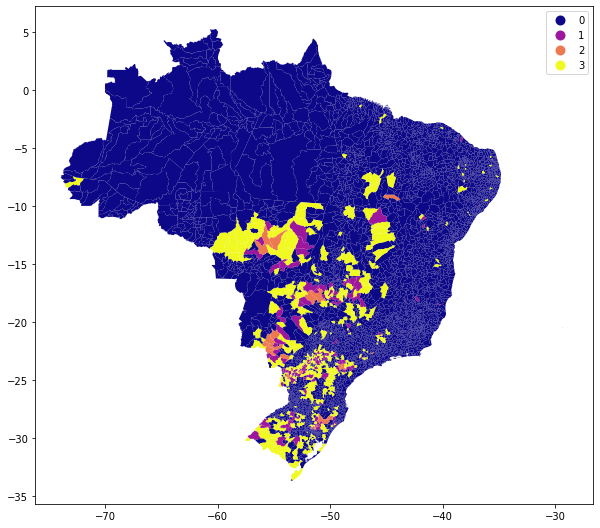

In [62]:
dados_centroids.plot(column='grupo', figsize=(10, 10), legend=True, cmap='plasma'); # , cmap='OrRd'

##  Spatially Constrained Hierarchical Clustering - K-Médias

In [63]:
w = Queen.from_dataframe(dados_br)
w.transform = 'r'

In [64]:
model = AgglomerativeClustering(distance_threshold=80, linkage='ward', connectivity=w.sparse,  n_clusters=None)
model.fit(XX)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=<5568x5568 sparse matrix of type '<class 'numpy.float64'>'
	with 28004 stored elements in Compressed Sparse Row format>,
                        distance_threshold=80, linkage='ward', memory=None,
                        n_clusters=None)

In [65]:
dados_centroids['grupo'] = model.labels_

In [66]:
dados_centroids['grupo'] = dados_centroids['grupo'].astype('category')

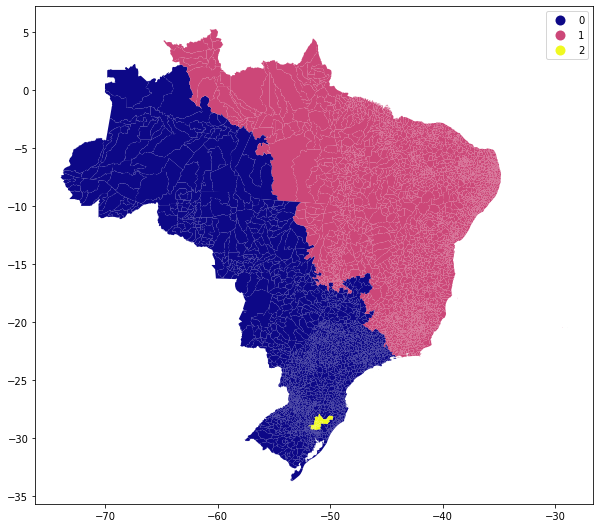

In [67]:
dados_centroids.plot(column='grupo', figsize=(10, 10), legend=True, cmap='plasma'); # , cmap='OrRd'

## Análise de agrupamento - Centroides - Outra distância

In [68]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

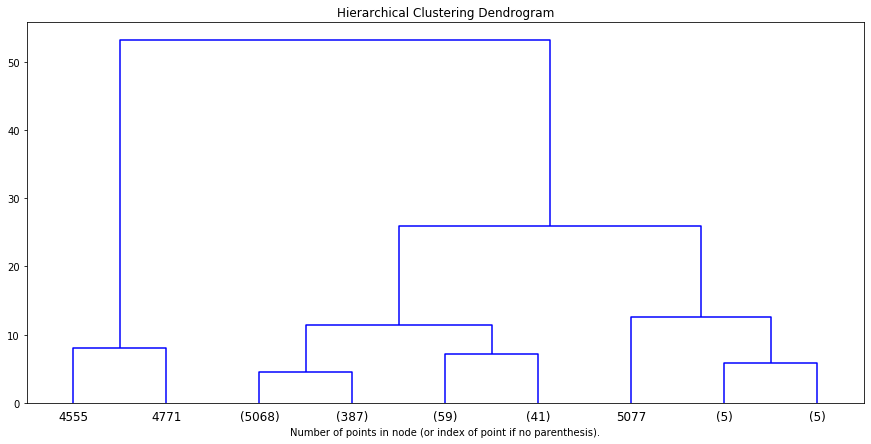

In [69]:
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=120, n_clusters=None, affinity='manhattan', linkage='average')

model = model.fit(XX)
plt.subplots(figsize=(15, 7))
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=3, color_threshold=0.1)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [70]:
k = 3

In [71]:
kmeans = AgglomerativeClustering(n_clusters=k, 
                                 affinity='manhattan', 
                                 linkage='average').fit(X)


In [72]:
# incluir no resultado dos escores dos dois primeiros CPs a informação sobre os grupos obtidos 
# com o método das k-médias
dados_centroids['grupo'] = kmeans.labels_

### Métricas

In [73]:
# métricas
print(
  round(metrics.calinski_harabasz_score(X, grupos.ravel()),2),
  round(davies_bouldin_score(X, grupos.ravel()),2),
  round(metrics.silhouette_score(X, grupos.ravel(), metric='euclidean'),2)  
)

4860.91 1.16 -0.05


In [74]:
# contagem de observações em cada grupo
dados_centroids.grupo.value_counts()

0    5558
1       9
2       1
Name: grupo, dtype: int64

### Mapa Grupos Centroides

In [75]:
dados_centroids['grupo'] = dados_centroids['grupo'].astype('category')

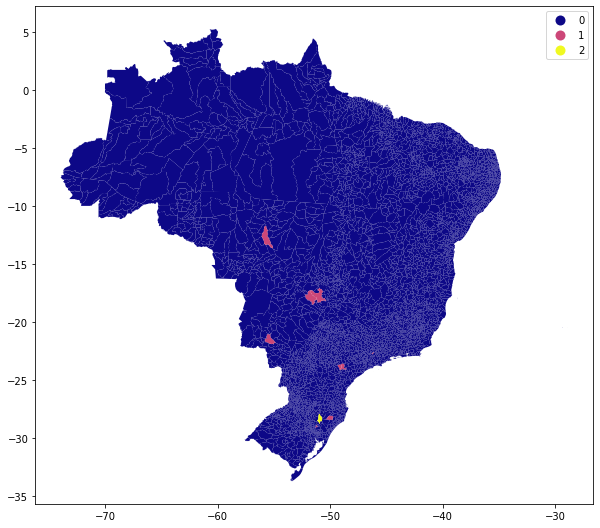

In [76]:
dados_centroids.plot(column='grupo', figsize=(10, 10), legend=True, cmap='plasma'); # , cmap='OrRd'